In [10]:
import pandas as pd

df = pd.read_csv('corpus.csv')
df

,Unnamed: 0,artist,title,year,album,lyrics,n_words,pageviews,contributors,url
0,1,Dry,94310,2012.0,Tôt ou tard,"[Paroles de ""94310"" ft. Madj, Larso & Stokas]\...",748,0,8,https://genius.com/Dry-94310-lyrics
1,2,Mafia K’1 Fry,Au bon vieux temps,2007.0,Jusqu’à la mort,"\nEt je les entends tous les Zoulous, ils parl...",958,7514,8,https://genius.com/Mafia-k1-fry-au-bon-vieux-t...
2,3,DJ Hamida,Attrape-Moi Si Tu Peux,NaN,Mix Party 2015,[Refrain : Charly Bell]\nOui je sais qu’t’as e...,367,0,4,https://genius.com/Dj-hamida-attrape-moi-si-tu...
3,4,Kery James,94 c’est le Barça Remix,NaN,NaN,"\nC'est pour les rudeboys, c'est pour les cail...",535,0,7,https://genius.com/Kery-james-94-cest-le-barca...
4,5,Dry,14 ans déjà,2013.0,Maintenant ou jamais,"[Paroles de ""14 ans déjà""]\n\n\nTu sais, j'cro...",653,5037,8,https://genius.com/Dry-14-ans-deja-lyrics
...,...,...,...,...,...,...,...,...,...,...
85018,85019,Bricksy & 3g,Akai,2024.0,But It Ain’t,"[Paroles de ""Akai"" ft. La Fève]\n\n\nFF7\nWalo...",471,0,7,https://genius.com/Bricksy-and-3g-akai-lyrics
85019,85020,Bricksy & 3g,I am GIA,2024.0,But It Ain’t,"[Paroles de ""I am GIA""]\n\n\nSa star\nIl me di...",522,0,4,https://genius.com/Bricksy-and-3g-i-am-gia-lyrics
85020,85021,Rafal,ROMEO,2024.0,NaN,\n\n\nPrépare le sparadrap\nJ'péterais ma tête...,393,0,4,https://genius.com/Rafal-romeo-lyrics
85021,85022,Aktéfräzé,"Alpha, kilo, tango, [é]cho... Triple comme au ...",1999.0,B.O.S.S. Vol. 1,\nComme au scrabble et...\n\n\nLa fine fleur d...,464,0,1,https://genius.com/Aktefraze-alpha-kilo-tango-...


# Sexism analysis

Huggingface model :  https://huggingface.co/annahaz/xlm-roberta-base-misogyny-sexism-indomain-mix-bal

In [11]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("annahaz/xlm-roberta-base-misogyny-sexism-indomain-mix-bal")
model = AutoModelForSequenceClassification.from_pretrained("annahaz/xlm-roberta-base-misogyny-sexism-indomain-mix-bal")

c:\miniconda\envs\env_1\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
# text = 'Ceci est une phrase neutre'
# text = 'Bonjour, je vous trouve très jolie'
text = 'T\'es bonne ouech'
# text = 'Chez moi, que de la bonne substance, normal elle sort d\'Amsterdam'
# text = 'C\'est une salope'
# text = 'Je vais te la mettre si t\'ouvres tes fesses'


inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

print(logits)

predicted_class_id = logits.argmax().item()
# model.config.id2label[predicted_class_id]
predicted_class_id

tensor([[ 2.7519, -3.4935]])


0

In [37]:
import re

def clean_text(text):
    # text = text.replace('\n', ' ')
    # text = text.replace('\r', ' ')
    text = re.sub(r'\[.*?\]', '', text) # remove text between brackets (title)
    text = re.sub(r'[^\w\s]', ' ', text) # remove punctuation
    return text

def violence_probability(line):
    inputs = tokenizer(line, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    # predicted_class_id = logits.argmax().item()
    # return model.config.id2label[predicted_class_id]
    return logits

def categorize(lyrics):
    # for each line of the lyrics, get the probability of violence and return the mean
    lyrics = clean_text(lyrics)
    lines = lyrics.split('\n')
    if len(lines) == 0:
        return None
    lines = [line for line in lines if line] # remove empty lines
    # print(lines)
    probabilities = [violence_probability(line) for line in lines]
    # print(probabilities)

    mean_probability = sum(probabilities) / len(probabilities)
    mean_probability = mean_probability.numpy()
    # print('mean probability : ', mean_probability)    
    # predicted_class_id = mean_probability.argmax().item()
    # mean_proba_classe = model.config.id2label[predicted_class_id]

    # get the class of each line
    classes = [model.config.id2label[proba.argmax().item()] for proba in probabilities]
    # print(classes)
    nb_violent_lines = len([cl for cl in classes if cl == '1'])
    nb_non_violent_lines = len([cl for cl in classes if cl == '0'])
    ratio_violent_lines = nb_violent_lines / (nb_violent_lines + nb_non_violent_lines)
    # print('ratio violent lines : ', ratio_violent_lines)

    # return mean_probability, ratio_violent_lines
    return ratio_violent_lines

lyrics = df['lyrics'][0]
categorize(lyrics)

0.21875

In [6]:
df_alkpote = df[df['artist'] == 'Alkpote']
for i in range(10):
    lyrics = df_alkpote.iloc[i]['lyrics']
    # print('lyrics : ', lyrics)
    print(categorize(lyrics))
    # print('\n\n\n\n')

(tensor([[-0.1422, -0.0194]]), 0.5888888888888889)
(tensor([[ 0.8407, -1.2274]]), 0.43283582089552236)
(tensor([[ 1.1938, -1.5892]]), 0.25)
(tensor([[ 1.5284, -1.9794]]), 0.24528301886792453)
(tensor([[ 1.2478, -1.6807]]), 0.28735632183908044)
(tensor([[ 1.5624, -2.0617]]), 0.18556701030927836)
(tensor([[ 0.5954, -0.9085]]), 0.4074074074074074)
(tensor([[ 1.1115, -1.5045]]), 0.2807017543859649)
(tensor([[-0.6203,  0.5877]]), 0.6111111111111112)
(tensor([[ 1.7283, -2.2697]]), 0.16666666666666666)


In [23]:
most_popular_artists = df[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(10)
df[df['artist'].isin(most_popular_artists.index)]

,Unnamed: 0,artist,title,year,album,lyrics,n_words,pageviews,contributors,url
45,46,Ninho,3 MAI 2025,2024.0,NaN,"[Paroles de ""3 MAI 2025""]\n\n\nHey\nBLN\nC'est...",344,7067,9,https://genius.com/Ninho-3-mai-2025-lyrics
112,113,Booba,Dolce Camara,2024.0,AD VITAM ÆTERNAM,"[Paroles de ""Dolce Camara"" ft. SDM]\n\n\nC'est...",612,61812,42,https://genius.com/Booba-dolce-camara-lyrics
116,117,Booba,Rebel,2024.0,AD VITAM ÆTERNAM,"\n\n\n""Herb...herb is a plant ! I mean...herbs...",297,23126,19,https://genius.com/Booba-rebel-lyrics
117,118,Booba,Saga,2024.0,AD VITAM ÆTERNAM,\n\n\nToujours entouré de mannequins\nToujours...,409,23283,18,https://genius.com/Booba-saga-lyrics
118,119,Booba,GM,2024.0,AD VITAM ÆTERNAM,"[Paroles de ""GM"" ft. Evil P & Gato]\n\n[Intro ...",745,8150,16,https://genius.com/Booba-gm-lyrics
...,...,...,...,...,...,...,...,...,...,...
84747,84748,JuL,On sent pas les coups,2024.0,Décennie,Album décénnie\n\nUne moto une paire de gant j...,523,0,8,https://genius.com/Jul-on-sent-pas-les-coups-l...
84748,84749,JuL,Découpage,2024.0,Décennie,"[Paroles de ""Découpage""]\n\n\nJette le cross d...",929,0,5,https://genius.com/Jul-decoupage-lyrics
84826,84827,GIMS,CYPHER,2024.0,LES DERNIÈRES VOLONTÉS DE MOZART (SYMPHONY),[Paroles issu d'un extrait Instagram]\n\n\n\nT...,235,0,4,https://genius.com/Gims-cypher-lyrics
84862,84863,GIMS,Bériz,2023.0,NaN,"\n\n\nJ'suis sur Bériz, plié comme dans l'dern...",206,0,1,https://genius.com/Gims-beriz-lyrics


In [25]:
# get 10 most popular artists (by number of pageviews on total on genius)
most_popular_artists = df[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(10)
dict_sexism_per_artist = {}
# apply categorize function to each artist
for artist in most_popular_artists.index:
    print('artist : ', artist)
    df_artist = df[df['artist'] == artist]
    # keep the 10 most popular songs of the artist
    df_artist = df_artist.sort_values(by='pageviews', ascending=False).head(10)
    sexism_index = []
    for i in range(len(df_artist)):
        # print('song : ', i)
        lyrics = df_artist.iloc[i]['lyrics']
        # print('lyrics : ', lyrics)
        print(f'song {i}: ', categorize(lyrics))
        # print('\n\n\n\n')
        sexism_index.append(categorize(lyrics))
    print('mean sexism index : ', sum(sexism_index) / len(sexism_index))
    dict_sexism_per_artist[artist] = sum(sexism_index) / len(sexism_index)
    
dict_sexism_per_artist


artist :  Booba
song 0:  [[ 1.3894185 -1.7724342]]
song 1:  [[ 0.4898666 -0.7644445]]
song 2:  [[ 1.1097819 -1.4830893]]
song 3:  [[ 1.8672497 -2.3786547]]
song 4:  [[ 1.8566532 -2.4070802]]
song 5:  [[ 2.842864  -3.4846933]]
song 6:  [[ 0.47479358 -0.6867693 ]]
song 7:  [[ 1.6403898 -2.1215732]]
song 8:  [[ 2.7712102 -3.4103951]]
song 9:  [[ 2.030371  -2.5669239]]
mean sexism index :  [[ 1.6472597 -2.1076057]]
artist :  PNL
song 0:  [[ 1.181485  -1.5203798]]
song 1:  [[ 1.2661186 -1.6578737]]
song 2:  [[ 1.702531  -2.1528542]]
song 3:  [[ 1.3650155 -1.8010157]]
song 4:  [[ 0.92152345 -1.2233695 ]]
song 5:  [[ 1.8900843 -2.4387767]]
song 6:  [[ 0.9207844 -1.3372955]]
song 7:  [[ 0.8258516 -1.1153988]]
song 8:  [[ 2.1761117 -2.7098408]]
song 9:  [[ 0.74501604 -1.0330144 ]]
mean sexism index :  [[ 1.2994521 -1.698982 ]]
artist :  Nekfeu
song 0:  [[ 2.4541824 -3.095093 ]]
song 1:  [[ 1.7855963 -2.3063416]]
song 2:  [[ 2.3387988 -2.9232154]]
song 3:  [[ 1.8440536 -2.330666 ]]
song 4:  [[ 0

{'Booba': array([[ 1.6472597, -2.1076057]], dtype=float32),
 'PNL': array([[ 1.2994521, -1.698982 ]], dtype=float32),
 'Nekfeu': array([[ 1.6889751, -2.1786733]], dtype=float32),
 'JuL': array([[ 1.5754545, -2.0203807]], dtype=float32),
 'Damso': array([[ 1.5484161, -1.9896809]], dtype=float32),
 'Stromae': array([[ 1.7934182, -2.3134754]], dtype=float32),
 'Lacrim': array([[ 1.0113986, -1.3544018]], dtype=float32),
 'SCH': array([[ 1.3225659, -1.7294012]], dtype=float32),
 'GIMS': array([[ 1.8208841, -2.3241336]], dtype=float32),
 'Ninho': array([[ 1.4084122, -1.8517656]], dtype=float32)}

In [ ]:
dict_sexism_per_artist = {
 'Booba': [[ 1.6472597, -2.1076057]],
 'PNL': [[ 1.2994521, -1.698982 ]],
 'Nekfeu': [[ 1.6889751, -2.1786733]],
 'JuL': [[ 1.5754545, -2.0203807]],
 'Damso': [[ 1.5484161, -1.9896809]],
 'Stromae': [[ 1.7934182, -2.3134754]],
 'Lacrim': [[ 1.0113986, -1.3544018]],
 'SCH': [[ 1.3225659, -1.7294012]],
 'GIMS': [[ 1.8208841, -2.3241336]],
 'Ninho': [[ 1.4084122, -1.8517656]]
}

#  Ran on 10 most popular artists, 10 most popular songs of each artist.
#  Mean probability of sexism for each line
#  Not the best results for this method

In [31]:
dict_sexism_per_artist = {
 'Booba': 0.257170327571141,
 'PNL': 0.26351553659396343,
 'Nekfeu': 0.19741556978637792,
 'JuL': 0.25273628374073737,
 'Damso': 0.22336866464022925,
 'Stromae': 0.1565392796540128,
 'Lacrim': 0.24765847217841816,
 'SCH': 0.29686305476982033,
 'GIMS': 0.18208886791723733,
 'Ninho': 0.2579591031593867
 }

#  Ran on 10 most popular artists, 50 most popular songs of each artist.
#  Ratio of sexist lines

In [ ]:
dict_sexism_per_artist = {'Booba': 0.22699345302331167,
'PNL': 0.28359488132143384,
 'Nekfeu': 0.21246815327388952,
 'JuL': 0.24954825073406037,
 'Damso': 0.23368095901844663,
 'Stromae': 0.1832890929235252,
 'Lacrim': 0.3243756242649442,
 'SCH': 0.27101350878843067,
 'GIMS': 0.19010585947866715,
 'Ninho': 0.26694453780239324}

# Ran on 10 most popular artists, 10 most popular songs of each artist.
# Ratio of sexist lines

In [29]:
# put the dict in the right format
for artist, sexism_index in dict_sexism_per_artist.items():
    # print(artist, sexism_index)
    sexism_probability = sexism_index[0][0] - sexism_index[0][1]
    # print('sexism probability : ', sexism_probability)
    dict_sexism_per_artist[artist] = sexism_probability

Text(0, 0.5, 'Sexism index')

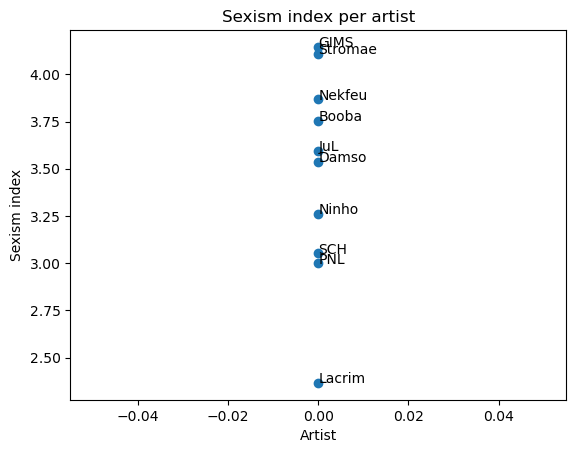

In [30]:
import matplotlib.pyplot as plt

plt.scatter([0] * len(dict_sexism_per_artist), dict_sexism_per_artist.values())
for i in range(len(dict_sexism_per_artist)):
    plt.text(0, list(dict_sexism_per_artist.values())[i], list(dict_sexism_per_artist.keys())[i])
plt.title('Sexism index per artist')
plt.xlabel('Artist')
plt.ylabel('Sexism index')

Text(0, 0.5, 'Sexism index')

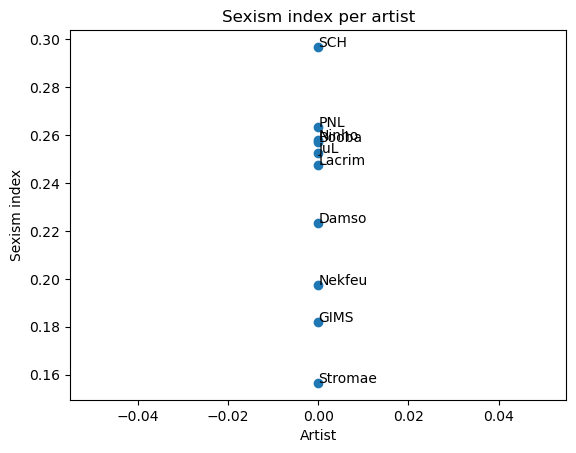

In [32]:
import matplotlib.pyplot as plt

plt.scatter([0] * len(dict_sexism_per_artist), dict_sexism_per_artist.values())
for i in range(len(dict_sexism_per_artist)):
    plt.text(0, list(dict_sexism_per_artist.values())[i], list(dict_sexism_per_artist.keys())[i])
plt.title('Sexism index per artist')
plt.xlabel('Artist')
plt.ylabel('Sexism index')

# Temporal analysis

In [35]:
df.year

0        2012
1        2007
2        <NA>
3        <NA>
4        2013
         ... 
85018    2024
85019    2024
85020    2024
85021    1999
85022    <NA>
Name: year, Length: 85023, dtype: Int64

In [36]:
df_per_year = df.groupby('year')
df_per_year

In [39]:
df['year'].unique()

<IntegerArray>
[2012, 2007, <NA>, 2013, 2014, 2020, 2024, 2023, 2006, 2008, 2022, 2011, 2018,
 2005, 1999, 2003, 2015, 2009, 2021, 2004, 2010, 1996, 2019, 2000, 2002, 2016,
 1998, 2025, 2017, 1995, 2001, 1997, 1991, 1994, 1993, 1992, 1990,    1, 1870,
   12,  666, 1905]
Length: 42, dtype: Int64

In [41]:
df.columns

Index(['Unnamed: 0', 'artist', 'title', 'year', 'album', 'lyrics', 'n_words',
       'pageviews', 'contributors', 'url'],
      dtype='object')

In [ ]:
df[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(10).index


Index(['Booba', 'PNL', 'Nekfeu', 'JuL', 'Damso', 'Stromae', 'Lacrim', 'SCH',
       'GIMS', 'Ninho'],
      dtype='object', name='artist')

In [47]:
df_clean = df[df['year']>= 1995]
sexism_total = {}
for year in range(1995, 2025):
    print('year : ', year)
    df_current_year = df_clean[df_clean['year'] == year]
    sexism_index_year = {}
    # keep only artist that were in the top 10 most popular artists of the year
    most_popular_artists = df_current_year[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(5).index
    for artist in most_popular_artists:
        print('artist : ', artist)
        df_current_artist = df_current_year[df_current_year['artist'] == artist]
        # keep the 10 most popular songs of the year for this artist
        df_current_artist = df_current_artist.sort_values(by='pageviews', ascending=False).head(10)
        if df_current_artist.shape[0] == 0:
            sexism_index_year[artist] = None
        else:
            sexism_index = []
            for i in range(len(df_current_artist)):
                lyrics = df_current_artist.iloc[i]['lyrics']
                sexism_index.append(categorize(lyrics))
            print('mean sexism index : ', sum(sexism_index) / len(sexism_index))
            sexism_index_year[artist] = sum(sexism_index) / len(sexism_index)
    print('sexism index year : ', sexism_index_year)
    sexism_total[year] = sexism_index_year

print("\n\n\n", sexism_total)   

year :  1995
artist :  Akhenaton
mean sexism index :  0.17122087265881908
artist :  Suprême NTM
mean sexism index :  0.10130338774211105
artist :  Ministère A.M.E.R.
mean sexism index :  0.07352941176470588
artist :  Lunatic
mean sexism index :  0.28403499817680544
artist :  Les Sages Poètes de la Rue
mean sexism index :  0.18596525747173803
sexism index year :  {'Akhenaton': 0.17122087265881908, 'Suprême NTM': 0.10130338774211105, 'Ministère A.M.E.R.': 0.07352941176470588, 'Lunatic': 0.28403499817680544, 'Les Sages Poètes de la Rue': 0.18596525747173803}
year :  1996
artist :  Doc Gynéco
mean sexism index :  0.21722747375732449
artist :  Lunatic
mean sexism index :  0.24042709867452136
artist :  Ideal J
mean sexism index :  0.2051718786367096
artist :  La Clinique
mean sexism index :  0.38202247191011235
artist :  Time Bomb (FRA)
mean sexism index :  0.23333333333333334
sexism index year :  {'Doc Gynéco': 0.21722747375732449, 'Lunatic': 0.24042709867452136, 'Ideal J': 0.20517187863670

In [48]:
# save the dict in a csv file
import csv

with open('sexism_total.csv', 'w') as f:
    for key in sexism_total.keys():
        f.write("%s,%s\n"%(key,sexism_total[key]))

In [49]:
sexism_total

{1995: {'Akhenaton': 0.17122087265881908,
  'Suprême NTM': 0.10130338774211105,
  'Ministère A.M.E.R.': 0.07352941176470588,
  'Lunatic': 0.28403499817680544,
  'Les Sages Poètes de la Rue': 0.18596525747173803},
 1996: {'Doc Gynéco': 0.21722747375732449,
  'Lunatic': 0.24042709867452136,
  'Ideal J': 0.2051718786367096,
  'La Clinique': 0.38202247191011235,
  'Time Bomb (FRA)': 0.23333333333333334},
 1997: {'IAM': 0.1740767211769216,
  'X-Men': 0.24050632911392406,
  'Passi': 0.2921123971304521,
  'Oxmo Puccino': 0.33714509295468814,
  'Akhenaton': 0.16324476650563607},
 1998: {'Oxmo Puccino': 0.2014682355552218,
  'Suprême NTM': 0.20277064354725943,
  'Ärsenik (Group)': 0.2703345141952038,
  'Manau': 0.1532998158698498,
  'Fonky Family': 0.16846806742600476},
 1999: {'113': 0.17102055878309386,
  'Rohff': 0.21782617264485613,
  'Neg’ Marrons': 0.2661472448057814,
  'Pit Baccardi': 0.2140703516079674,
  'Koma (FRA)': 0.10542294557695882},
 2000: {'Lunatic': 0.15321236184503823,
  'Neg

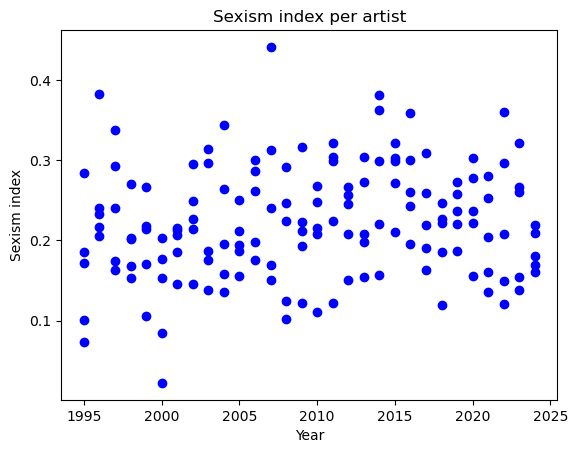

In [52]:
def plot_analysis(sexism_total):
    for year, dict_sexism_per_artist in sexism_total.items():
        plt.scatter([year] * len(dict_sexism_per_artist), dict_sexism_per_artist.values(), c='blue')
        # for i in range(len(dict_sexism_per_artist)):
            # plt.text(year, list(dict_sexism_per_artist.values)[i], list(dict_sexism_per_artist.keys())[i])
    plt.title('Sexism index per artist')
    plt.xlabel('Year')
    plt.ylabel('Sexism index')

plot_analysis(sexism_total)


# Tokenization

In [2]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [11]:
from nltk.tokenize import word_tokenize

sample_text = "Une phrase en français et avec un accent étizofnoz. Une balle dans la tête"
tokens = word_tokenize(sample_text)
tokens

['Une',
 'phrase',
 'en',
 'français',
 'et',
 'avec',
 'un',
 'accent',
 'étizofnoz',
 '.',
 'Une',
 'balle',
 'dans',
 'la',
 'tête']

In [ ]:
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# text_to_tokenize = 'This is a sample text'
# tokens = tokenizer.tokenize(text_to_tokenize)
# tokens

# df['tokens'] = df['lyrics'].apply(tokenizer.tokenize)
# df['tokens']

['this', 'is', 'a', 'sample', 'text']

In [ ]:
import re

def clean_text(text):
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = re.sub(r'\[.*?\]', '', text)
    # remove punctuation and replace by space
    text = re.sub(r'[^\w\s]', ' ', text)
    return text

0        [Paroles de "94310" ft. Madj, Larso & Stokas]\...
1        \nEt je les entends tous les Zoulous, ils parl...
2        [Refrain : Charly Bell]\nOui je sais qu’t’as e...
3        \nC'est pour les rudeboys, c'est pour les cail...
4        [Paroles de "14 ans déjà"]\n\n\nTu sais, j'cro...
                               ...                        
85018    [Paroles de "Akai" ft. La Fève]\n\n\nFF7\nWalo...
85019    [Paroles de "I am GIA"]\n\n\nSa star\nIl me di...
85020    \n\n\nPrépare le sparadrap\nJ'péterais ma tête...
85021    \nComme au scrabble et...\n\n\nLa fine fleur d...
85022    Un début de janvier, si j'ai bien su compter\n...
Name: lyrics, Length: 85023, dtype: object

In [28]:
word_tokenize(clean_text(str(df['lyrics'][0])))

df['tokens'] = df['lyrics'].apply(str).apply(clean_text).apply(word_tokenize)
df['tokens']

0        [Un, balle, dans, la, tête, je, te, la, place,...
1        [Et, je, les, entends, tous, les, Zoulous, ils...
2        [Oui, je, sais, qu, t, as, envie, On, cherche,...
3        [C, est, pour, les, rudeboys, c, est, pour, le...
4        [Tu, sais, j, crois, qu, j, ai, pas, réalisé, ...
                               ...                        
85018    [FF7, Walone, J, voulais, juste, baiser, le, g...
85019    [Sa, star, Il, me, dit, qu, j, suis, sa, star,...
85020    [Prépare, le, sparadrap, J, péterais, ma, tête...
85021    [Comme, au, scrabble, et, La, fine, fleur, des...
85022    [Un, début, de, janvier, si, j, ai, bien, su, ...
Name: tokens, Length: 85023, dtype: object

In [17]:
text = df['lyrics'][0]
print(text)
text = clean_text(text)
print('clean text\n\n\n\n', text)

tokens = word_tokenize(text)
print(tokens)


[Paroles de "94310" ft. Madj, Larso & Stokas]


Un balle dans la tête, je te la place comme Beckham
Je vais te la mettre si t'ouvres tes fesses, Orly-mite déboule en bécane
Mon son dans l'illicite comme tous ces dealers de came
Le 9.4.310 puissance de frappe, qu'il y ait pas d'amalgame
C'est qui qui fait du bruit, dites-moi c'est quoi ce vacarme ?
C'est S.T.O.K.A.S le mec de tess que personne ricane
(La Rue) pardonne pas donc forcément j'ai pas d'état d'âme
J'suis dans la street, j'suis dans les blocs et derrière moi j'laisse deux trois cadavres
Chez moi, que de la bonne substance, normal elle sort d'Amsterdam
Orly un phénomène, les vrais le savent on vient vous faire mal
J'ai le flair, je le ressens les khey comme n'importe quel animal
J'ai les crocs, j'ai envie de tout niquer les khey donc j'resterai radical
Le Val de Marne (Le Val de Meurtre) restera dans les annales
On défonce au MIC bien pire encore qu'un bon joint de zamal
C'est le 9.4.310, la zone est bouillante, la zone est dan